## 1A

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('AP004.csv')
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17


melihat sekilas bentuk dan isi data untuk memahami struktur dan format nilai-nilainya.

##### membersihkan nama kolom dari spasi atau karakter tersembunyi(jika ada)

In [6]:
df.columns = df.columns.str.strip()

In [7]:
df.columns.tolist()

['From Date',
 'To Date',
 'PM2.5 (ug/m3)',
 'PM10 (ug/m3)',
 'NO (ug/m3)',
 'NO2 (ug/m3)',
 'NOx (ppb)',
 'NH3 (ug/m3)',
 'SO2 (ug/m3)',
 'CO (mg/m3)',
 'Ozone (ug/m3)',
 'Benzene (ug/m3)',
 'Toluene (ug/m3)',
 'Eth-Benzene (ug/m3)',
 'MP-Xylene (ug/m3)',
 'Temp (degree C)',
 'RH (%)',
 'WS (m/s)',
 'WD (degree)',
 'SR (W/mt2)',
 'BP (mmHg)',
 'VWS (m/s)',
 'AT (degree C)',
 'RF (mm)',
 'Xylene (ug/m3)']

cek nama kolom

#### cek data type dari tiap variable

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 non-null 

cek struktrur dataset

##### konversi kolom tanggal ke format datetime

In [18]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['To Date'] = pd.to_datetime(df['To Date'])

Format datetime dibutuhkan untuk analisis time series. Set index time series membantu saat membuat window input-output untuk LSTM.

##### Statistik deskriptif

In [22]:
print(df.describe())

                 From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
count                48802                48802   46344.000000  46917.000000   
mean   2020-06-18 06:30:00  2020-06-18 07:30:00      34.821967     71.598595   
min    2017-09-05 14:00:00  2017-09-05 15:00:00       0.250000      0.250000   
25%    2019-01-26 22:15:00  2019-01-26 23:15:00      12.000000     34.500000   
50%    2020-06-18 06:30:00  2020-06-18 07:30:00      25.000000     59.750000   
75%    2021-11-08 14:45:00  2021-11-08 15:45:00      51.250000    100.500000   
max    2023-03-31 23:00:00  2023-04-01 00:00:00     723.000000    835.500000   
std                    NaN                  NaN      30.785200     48.312579   

         NO (ug/m3)   NO2 (ug/m3)     NOx (ppb)   NH3 (ug/m3)   SO2 (ug/m3)  \
count  47244.000000  47224.000000  46628.000000  47140.000000  46649.000000   
mean       2.509505     15.284711     10.025558     13.382927      8.498869   
min        0.030000      0.100000      0.0

##### cek missing value

In [25]:
print(df.isnull().sum())

From Date                  0
To Date                    0
PM2.5 (ug/m3)           2458
PM10 (ug/m3)            1885
NO (ug/m3)              1558
NO2 (ug/m3)             1578
NOx (ppb)               2174
NH3 (ug/m3)             1662
SO2 (ug/m3)             2153
CO (mg/m3)              2415
Ozone (ug/m3)           1646
Benzene (ug/m3)         1888
Toluene (ug/m3)         1894
Eth-Benzene (ug/m3)    24814
MP-Xylene (ug/m3)       9546
Temp (degree C)        27203
RH (%)                  1438
WS (m/s)                1427
WD (degree)             1429
SR (W/mt2)              1656
BP (mmHg)               1429
VWS (m/s)               1626
AT (degree C)           1516
RF (mm)                 1292
Xylene (ug/m3)          1727
dtype: int64


##### heatmap

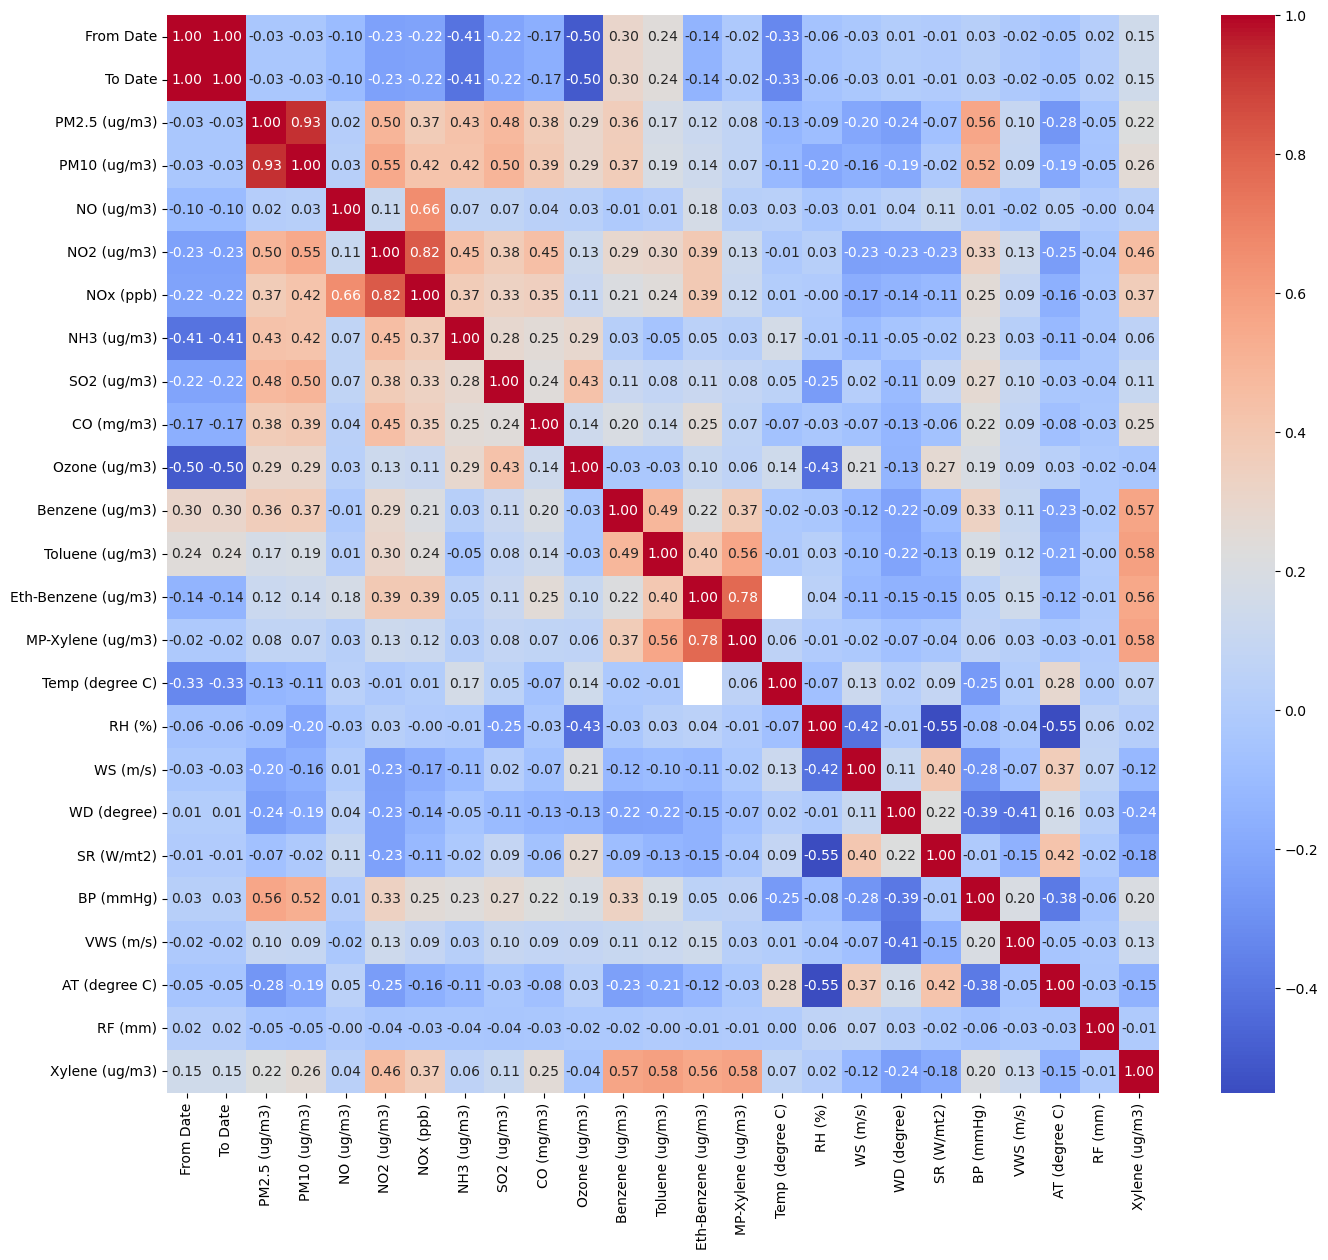

In [28]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

### handling missing value

##### Hapus kolom dengan missing value lebih dari 30%

In [31]:
missing_ratio = df.isnull().sum() / len(df)
df = df.loc[:, missing_ratio < 0.3]

##### hapus baris baris yang masih ada missing value

In [33]:
df.dropna(inplace=True)

##### cek kembali missing value dari tiap varible

In [38]:
df.isnull().sum()

From Date            0
To Date              0
PM2.5 (ug/m3)        0
PM10 (ug/m3)         0
NO (ug/m3)           0
NO2 (ug/m3)          0
NOx (ppb)            0
NH3 (ug/m3)          0
SO2 (ug/m3)          0
CO (mg/m3)           0
Ozone (ug/m3)        0
Benzene (ug/m3)      0
Toluene (ug/m3)      0
MP-Xylene (ug/m3)    0
RH (%)               0
WS (m/s)             0
WD (degree)          0
SR (W/mt2)           0
BP (mmHg)            0
VWS (m/s)            0
AT (degree C)        0
RF (mm)              0
Xylene (ug/m3)       0
dtype: int64

## 1B pembentukan data time series untuk LSTM

#### menentukan fitur dan target

In [42]:
target_col = 'AT (degree C)'

target yang diprediksi

In [45]:
feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

semua kolom numerik kecuali target akan jadi fitur

#### normalisasi data

##### Buat scaler untuk fitur dan target

In [50]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

##### fit & transform

In [53]:
X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[[target_col]])

#### sliding window

##### target 1 jam kedepan dan window size = 5 (untuk 5 jam sebelumnya)

In [57]:
def create_sequences(X, y, window_size):
    X_seq = []
    y_seq = []
    for i in range(window_size, len(X) - 1):
        X_seq.append(X[i - window_size:i])
        y_seq.append(y[i + 1])  
    return np.array(X_seq), np.array(y_seq)
    
window_size = 5
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

Fungsi create_sequences digunakan untuk menghasilkan data time series dalam format (samples, time_steps, features). Untuk setiap waktu t, fungsi mengambil X[t-5:t] sebagai input dan y[t+1] sebagai target, sehingga model dapat mempelajari hubungan antara fitur lingkungan pada lima jam sebelumnya dengan nilai AT satu jam setelahnya. Proses ini menghasilkan array X_seq dengan dimensi 3D dan y_seq dengan dimensi 2D

#### split Train-Test-Val

##### hitung indeks split

In [62]:
n_total = len(X_seq)
n_train = int(0.8 * n_total)
n_valid = int(0.1 * n_total)

##### split

In [65]:
X_train, y_train = X_seq[:n_train], y_seq[:n_train]
X_val, y_val = X_seq[n_train:n_train + n_valid], y_seq[n_train:n_train + n_valid]
X_test, y_test = X_seq[n_train + n_valid:], y_seq[n_train + n_valid:]

##### bentuk akhir (batch, time_step, features)

In [68]:
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

Shape X_train: (28349, 5, 20)
Shape y_train: (28349, 1)


Data yang telah dibentuk dalam format sekuens kemudian dibagi menjadi tiga subset secara berurutan: 80% untuk training, 10% untuk validasi, dan 10% untuk testing. Karena ini data time series, pembagian dilakukan berdasarkan urutan waktu agar tidak terjadi data leakage. Pembagian ini memastikan bahwa model dilatih pada data masa lalu dan diuji pada data yang belum pernah dilihat sebelumnya.



## 1C Model LSTM Baseline (Keras)

##### model sequential

In [73]:
model_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(10),
    Dense(1, activation='linear')
])

##### compile model

In [76]:
model_lstm.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae']
)

##### ringkasa model

In [79]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

##### train model

In [82]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0410 - mae: 0.1405 - val_loss: 0.0198 - val_mae: 0.1198
Epoch 2/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0066 - mae: 0.0641 - val_loss: 0.0110 - val_mae: 0.0890
Epoch 3/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0055 - mae: 0.0580 - val_loss: 0.0147 - val_mae: 0.1057
Epoch 4/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0052 - mae: 0.0566 - val_loss: 0.0120 - val_mae: 0.0932
Epoch 5/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0050 - mae: 0.0552 - val_loss: 0.0119 - val_mae: 0.0931
Epoch 6/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0050 - mae: 0.0551 - val_loss: 0.0129 - val_mae: 0.0978
Epoch 7/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0048 - mae: 0.0542 - val_loss: 0.0143 - val_mae: 0.1044
Epoch 8/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0048 - mae: 0.0538 - val_loss: 0.0130 - val_mae: 0.0978
Epoch 9/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - 

## 1D Modifikasi Model

In [84]:
model_mod = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_mod.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model_mod.summary()

history_mod = model_mod.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 5, 64)               │          21,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,209 (133.63 KB)

 Trainable params: 34,209 (133.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.0251 - mae: 0.1134 - val_loss: 0.0192 - val_mae: 0.1210
Epoch 2/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0078 - mae: 0.0699 - val_loss: 0.0164 - val_mae: 0.1146
Epoch 3/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0065 - mae: 0.0636 - val_loss: 0.0169 - val_mae: 0.1161
Epoch 4/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0057 - mae: 0.0590 - val_loss: 0.0118 - val_mae: 0.0954
Epoch 5/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0052 - mae: 0.0564 - val_loss: 0.0105 - val_mae: 0.0893
Epoch 6/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.0048 - mae: 0.0542 - val_loss: 0.0138 - val_mae: 0.1047
Epoch 7/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0046 - mae: 0.0527 - val_loss: 0.0152 - val_mae: 0.1096
Epoch 8/100
886/886 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0045 - mae: 0.0520 - val_loss: 0.0144 - val_mae: 0.1069
Epoch 9/100
886/886 ━━━━━━━━━━━━

## 1E Evaluasi Model Baseline & Modifikasi

#### prediksi pada dataset

In [86]:
y_pred_baseline = model_lstm.predict(X_test)
y_pred_mod = model_mod.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


#### transformasi balik ke skala asli

In [88]:
y_pred_baseline_inv = scaler_y.inverse_transform(y_pred_baseline)
y_pred_mod_inv = scaler_y.inverse_transform(y_pred_mod)
y_test_inv = scaler_y.inverse_transform(y_test)

#### evaluasi kinerja kedua model

In [92]:
mae_baseline = mean_absolute_error(y_test_inv, y_pred_baseline_inv)
mse_baseline = mean_squared_error(y_test_inv, y_pred_baseline_inv)
r2_baseline = r2_score(y_test_inv, y_pred_baseline_inv)

mae_mod = mean_absolute_error(y_test_inv, y_pred_mod_inv)
mse_mod = mean_squared_error(y_test_inv, y_pred_mod_inv)
r2_mod = r2_score(y_test_inv, y_pred_mod_inv)

#### hasil evaluasi

In [94]:
print("=== Model Baseline ===")
print(f"MAE  : {mae_baseline:.4f}")
print(f"MSE  : {mse_baseline:.4f}")
print(f"R²   : {r2_baseline:.4f}\n")

print("=== Model Modifikasi ===")
print(f"MAE  : {mae_mod:.4f}")
print(f"MSE  : {mse_mod:.4f}")
print(f"R²   : {r2_mod:.4f}")

=== Model Baseline ===
MAE  : 4.6569
MSE  : 28.1302
R²   : -2.7307

=== Model Modifikasi ===
MAE  : 5.0937
MSE  : 32.7710
R²   : -3.3462


##### analisa

Selain perubahan bertahap yang dilakukan pada struktur model, hasil evaluasi menunjukkan bahwa meskipun terjadi penurunan nilai error secara konsisten, model tetap menghasilkan R² negatif, bahkan pada versi modifikasi terbaik. Hal ini mengindikasikan bahwa, meskipun prediksi model semakin mendekati nilai aktual (ditunjukkan oleh penurunan MAE dan MSE), model belum mampu secara efektif menjelaskan proporsi variasi pada target (AT) yang ada dalam data validasi/test.

Salah satu penyebabnya bisa berasal dari kompleksitas dinamika atmosferik yang tidak sepenuhnya tertangkap oleh input dalam jendela waktu 5 jam sebelumnya. Dengan kata lain, model hanya belajar dari konteks jangka pendek, padahal mungkin dibutuhkan informasi historis yang lebih panjang atau fitur tambahan (seperti waktu dalam hari, musim, atau zona lokasi) untuk mendapatkan representasi yang lebih baik terhadap fluktuasi temperatur.

Selain itu, nilai R² negatif juga bisa disebabkan oleh perbedaan distribusi antara data latih dan data validasi, terutama jika ada outlier, noise tinggi, atau missing value sebelumnya yang memberi dampak terhadap pola. Meskipun preprocessing telah dilakukan, potensi data imbalance dalam fluktuasi suhu atau kondisi ekstrem bisa membuat model sulit untuk mengeneralisasi. Meskipun dropout telah membantu regularisasi, jika terlalu besar atau berada di posisi yang kurang tepat, ia juga dapat menghambat pembelajaran pola penting.

Dengan demikian, meskipun arsitektur sudah dimodifikasi secara bertahap dan berhasil menurunkan error, performa regresi secara keseluruhan masih memiliki ruang untuk ditingkatkan. Ke depan, pendekatan seperti memperpanjang window input (misalnya 12 atau 24 jam), menambahkan informasi waktu (time features), atau mempertimbangkan hybrid model (CNN + LSTM, atau attention mechanism) bisa menjadi langkah yang layak dieksplorasi.


## NO 1F (Bonus Question)

Ya, problem ini **sangat memungkinkan** untuk diselesaikan menggunakan pendekatan **time series multivariate**. Hal ini dikarenakan prediksi yang dilakukan tidak hanya bergantung pada satu variabel waktu (seperti AT atau suhu udara), tetapi juga dipengaruhi oleh banyak variabel lain yang berubah seiring waktu, seperti konsentrasi polutan (CO, NO2, Ozone, dll), kelembaban (RH), tekanan udara (BP), kecepatan angin (WS), dan sebagainya. Semua variabel ini berperan dalam menentukan kondisi kualitas udara dan temperatur di waktu mendatang.

Sebuah problem dapat dikategorikan sebagai **time series multivariate** jika:
1. Terdapat **lebih dari satu fitur atau variabel input** yang terekam secara **berurutan dalam waktu**.
2. Semua fitur tersebut **berkorelasi secara waktu** dan dapat memengaruhi target prediksi.
3. Target yang diprediksi (dalam hal ini `AT`, Air Temperature) dipengaruhi oleh kombinasi variabel input tersebut.

Dalam kasus ini, dataset memuat banyak variabel yang semuanya direkam setiap jam, sehingga memenuhi syarat untuk disebut multivariate time series. Jika hanya menggunakan satu fitur historis untuk prediksi (misalnya hanya `AT` masa lalu), itu disebut univariate. Tapi dengan menggunakan `AT` bersama fitur-fitur lain yang relevan di waktu sebelumnya, maka pendekatannya menjadi multivariate, dan ini dapat meningkatkan akurasi model karena memperkaya konteks prediksi.

Dengan demikian, pendekatan multivariate time series tidak hanya mungkin, tetapi memang **lebih tepat digunakan** untuk masalah ini.


link video :
https://youtu.be/iqtl6ICM28U
